# Title: “Car Price Prediction Using Machine Learning”
This notebook predicts the selling price of cars using machine learning. 
The dataset contains features like car name, year of manufacture, kilometers driven, fuel type, transmission, seller type, and number of owners.
The goal is to build a model that can estimate the price of a car accurately.


We will use Python libraries like pandas, numpy, matplotlib, seaborn for data analysis and visualization,
and scikit-learn for machine learning models.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import  LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
import warnings
warnings.filterwarnings('ignore')


Load and Inspect Data

In [3]:
data = pd.read_csv('CarPrice_Assignment.csv')
data.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [4]:
data.shape

(205, 26)

Get a summary of column types and missing values


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

Extract car brand from CarName and drop unnecessary columns.

CarBrand will be used as a categorical feature.

 CarName and car_ID are removed.


In [6]:
# Extract brand
data['CarBrand'] = data['CarName'].str.split(' ').str[0]
data = data.drop('CarName', axis=1)

In [7]:
data = data.drop('car_ID', axis=1)


Visualize relationships between features and selling price


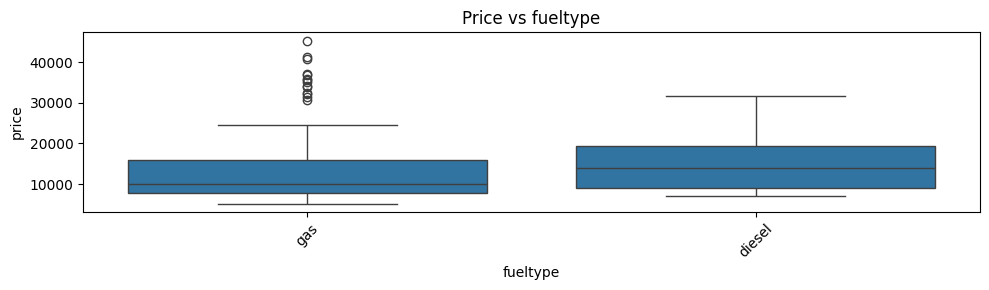

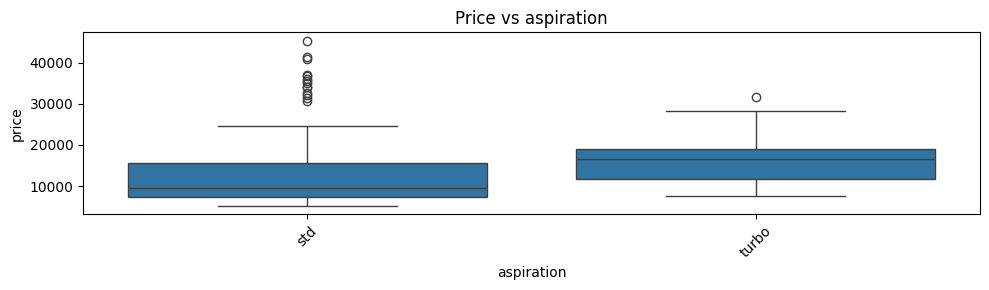

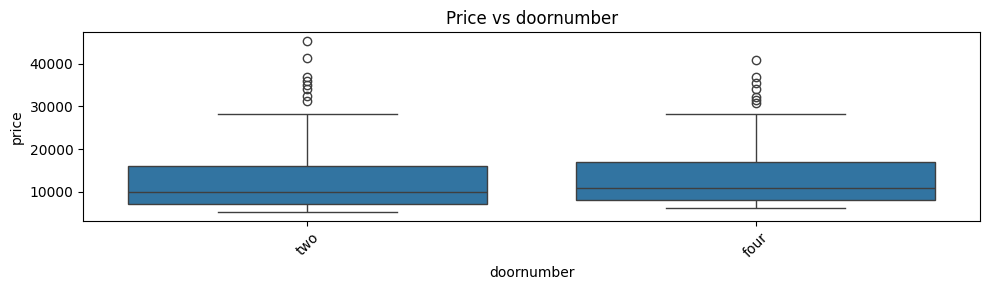

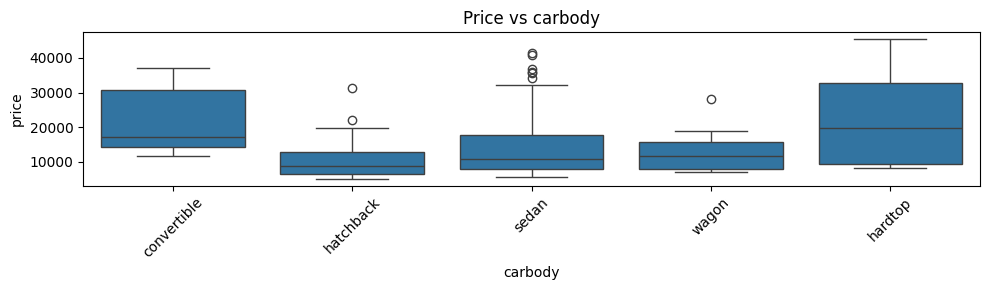

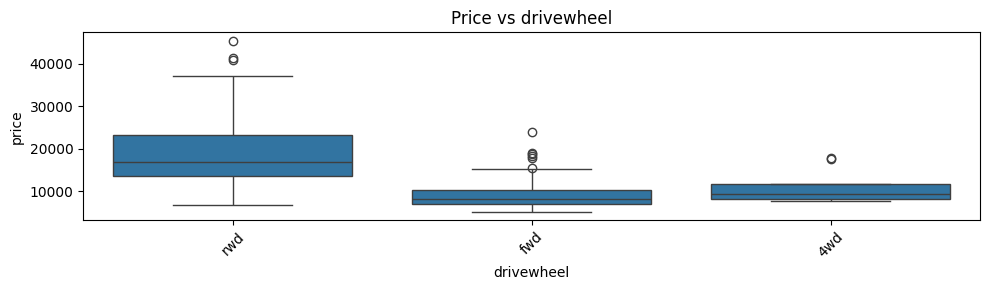

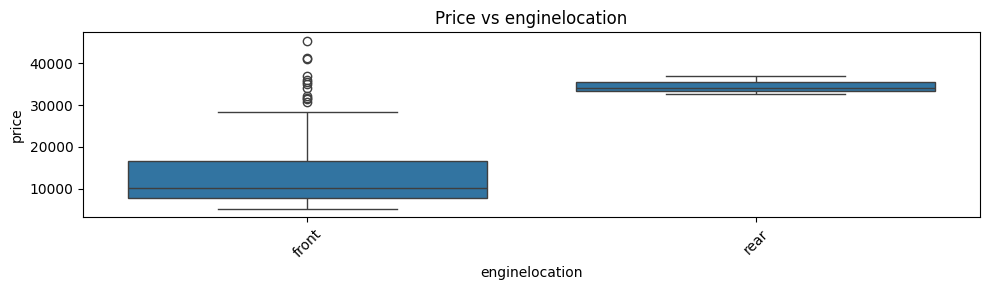

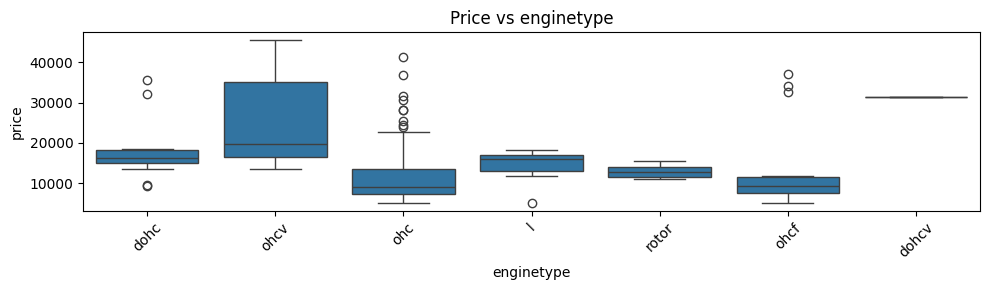

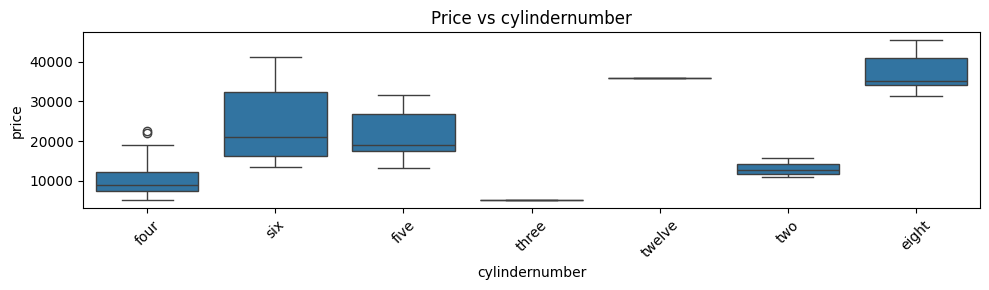

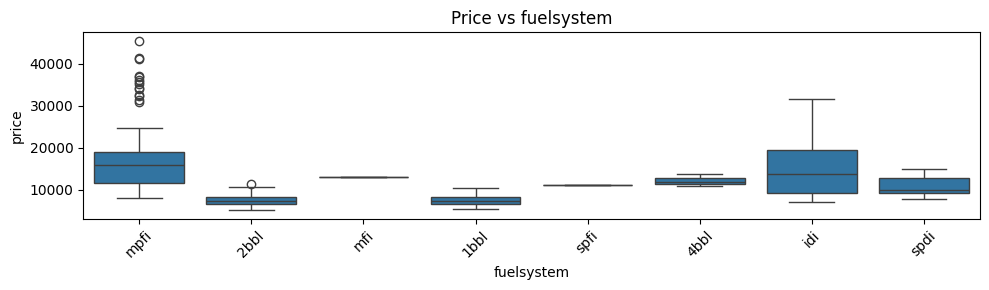

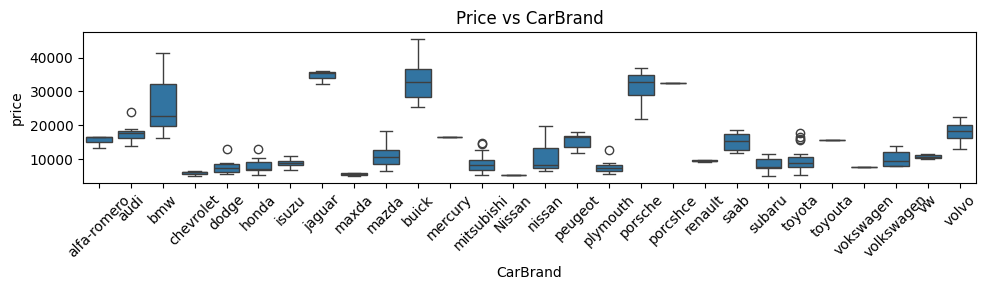

In [8]:
object_columns = data.select_dtypes(include='object').columns
for col in object_columns:
    plt.figure(figsize=(10,3))
    sns.boxplot(x=col, y='price', data=data)
    plt.xticks(rotation=45)
    plt.title(f"Price vs {col}")
    plt.tight_layout()
    plt.show()

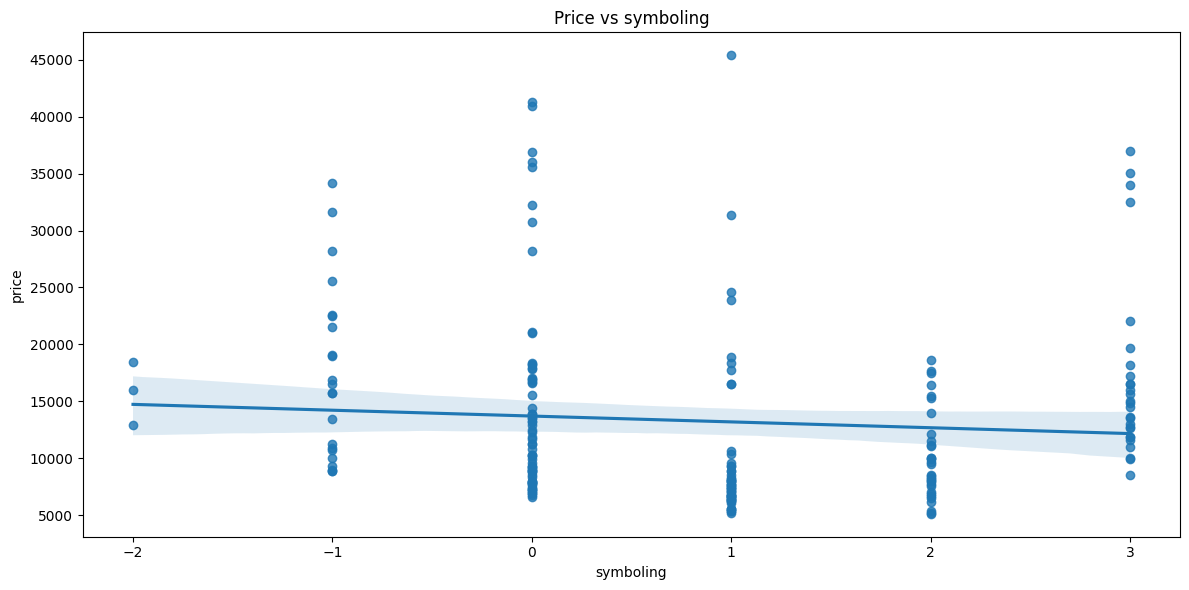

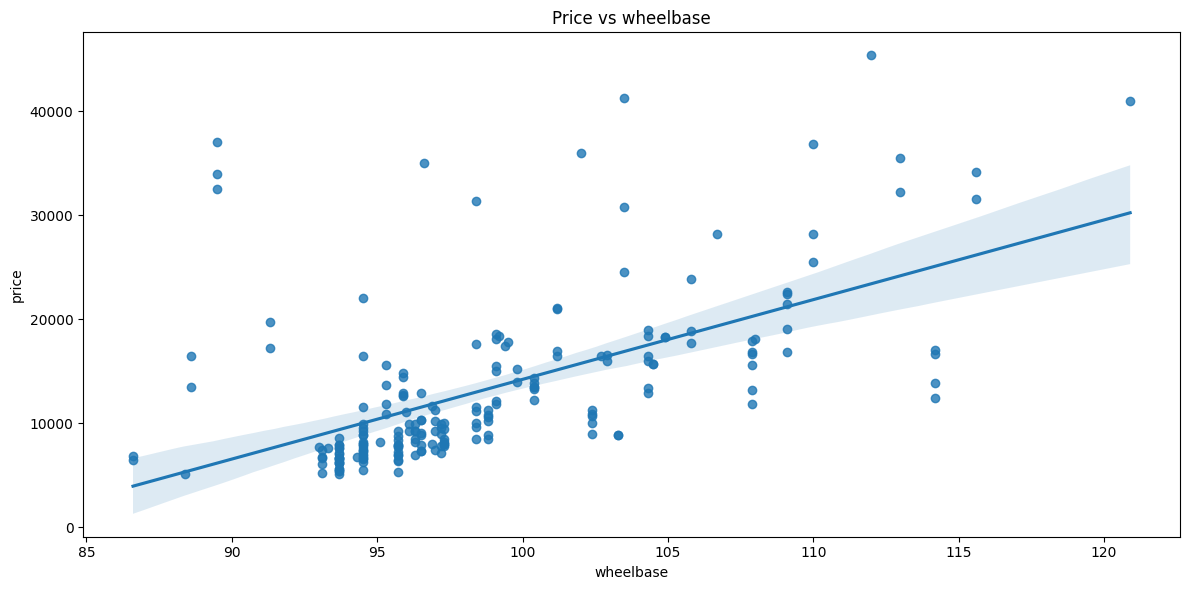

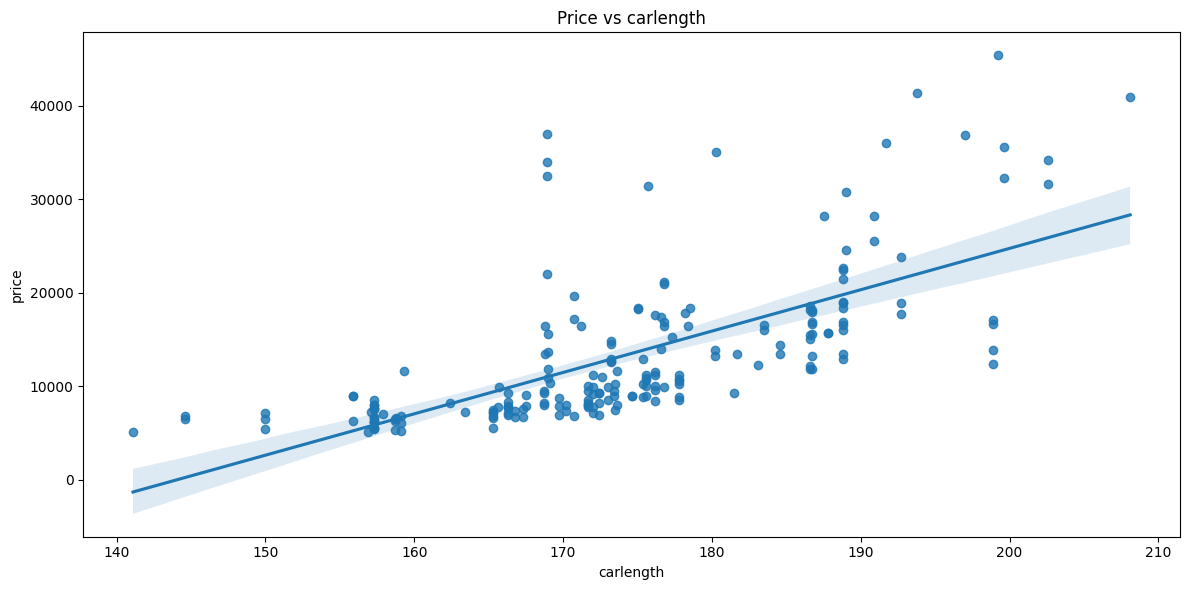

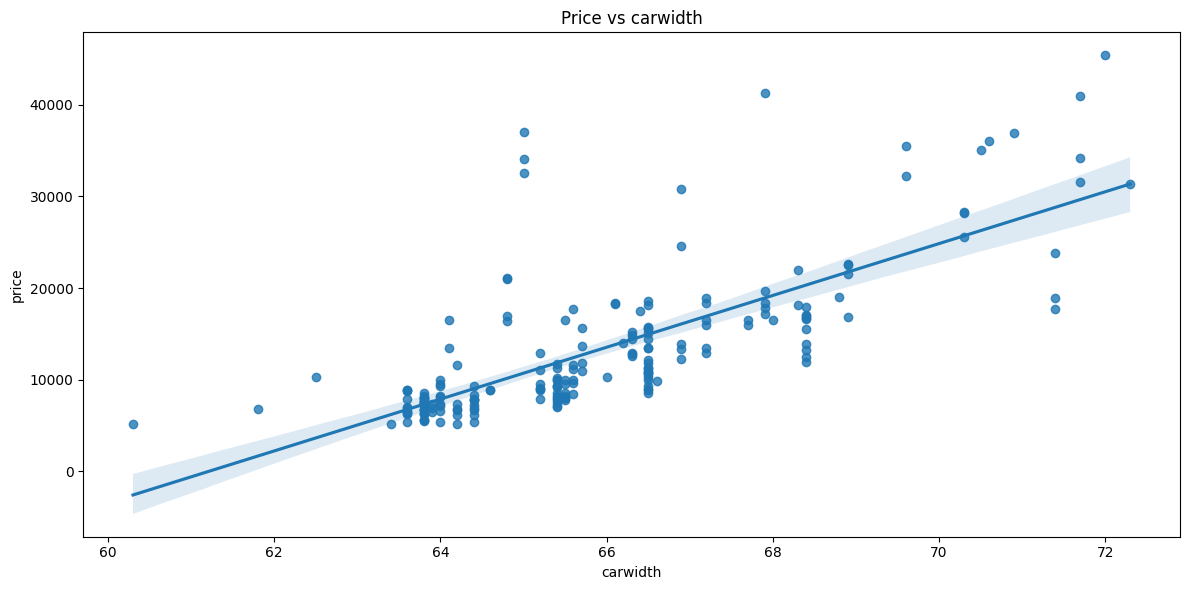

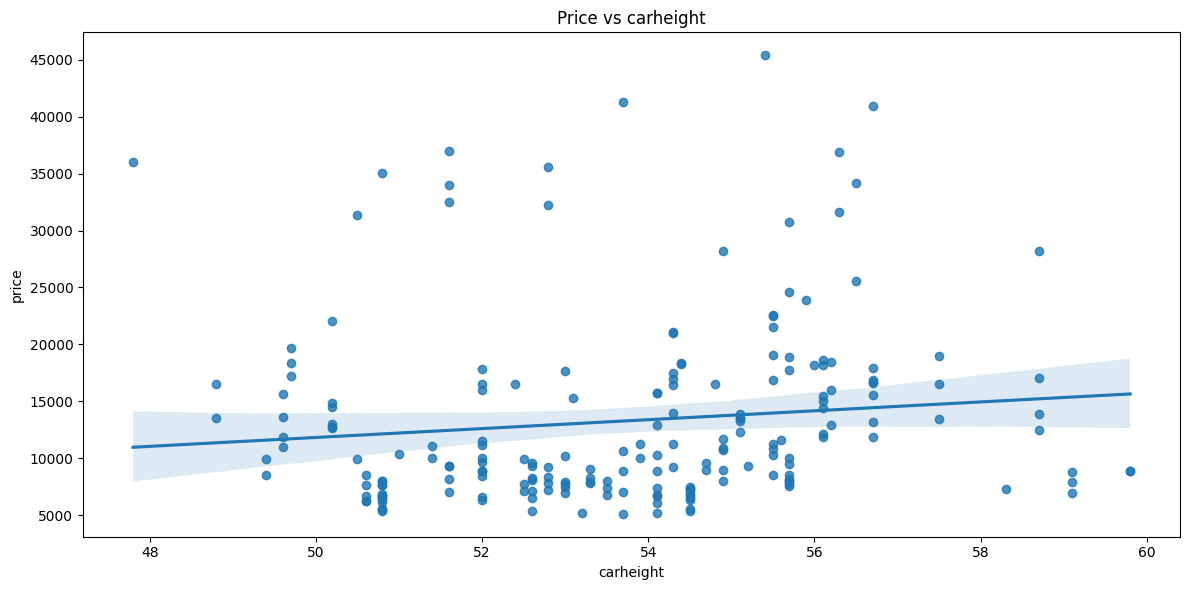

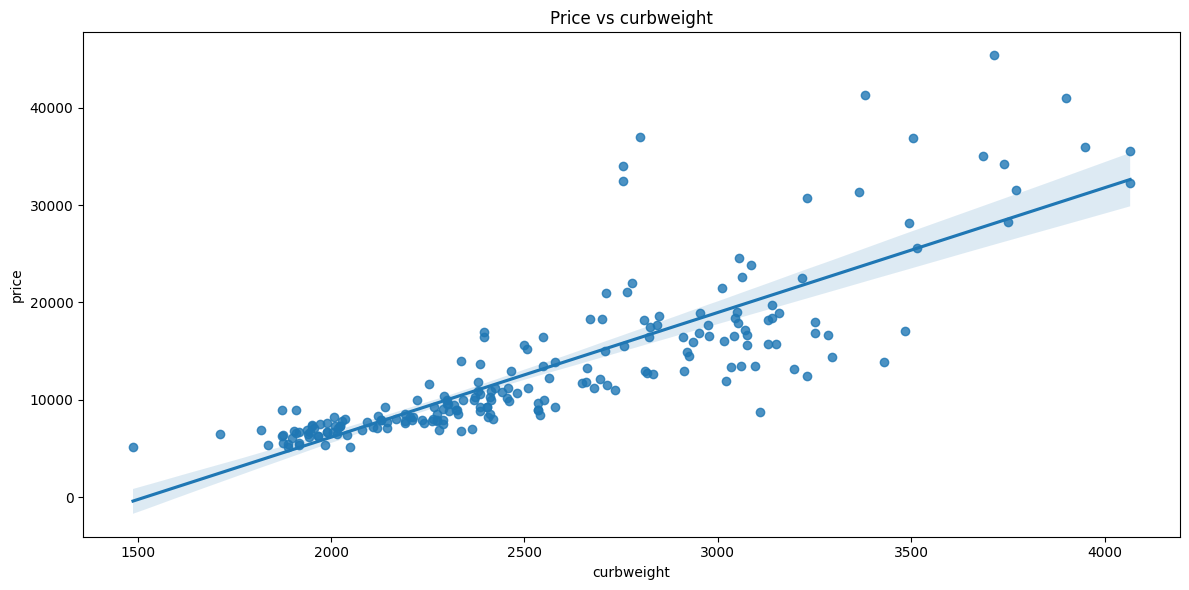

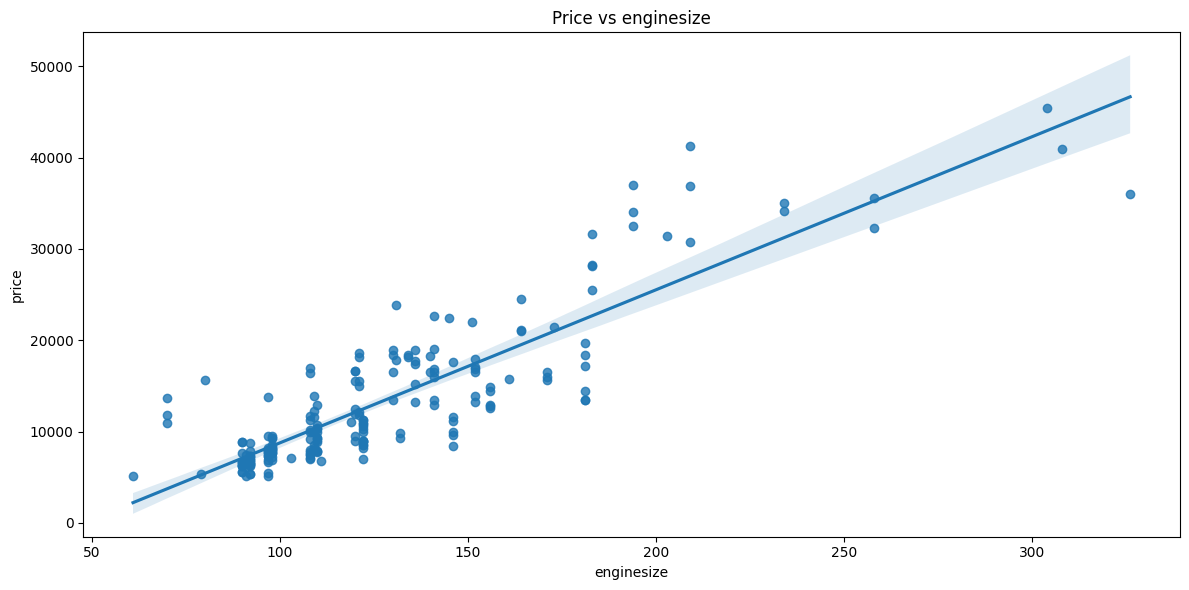

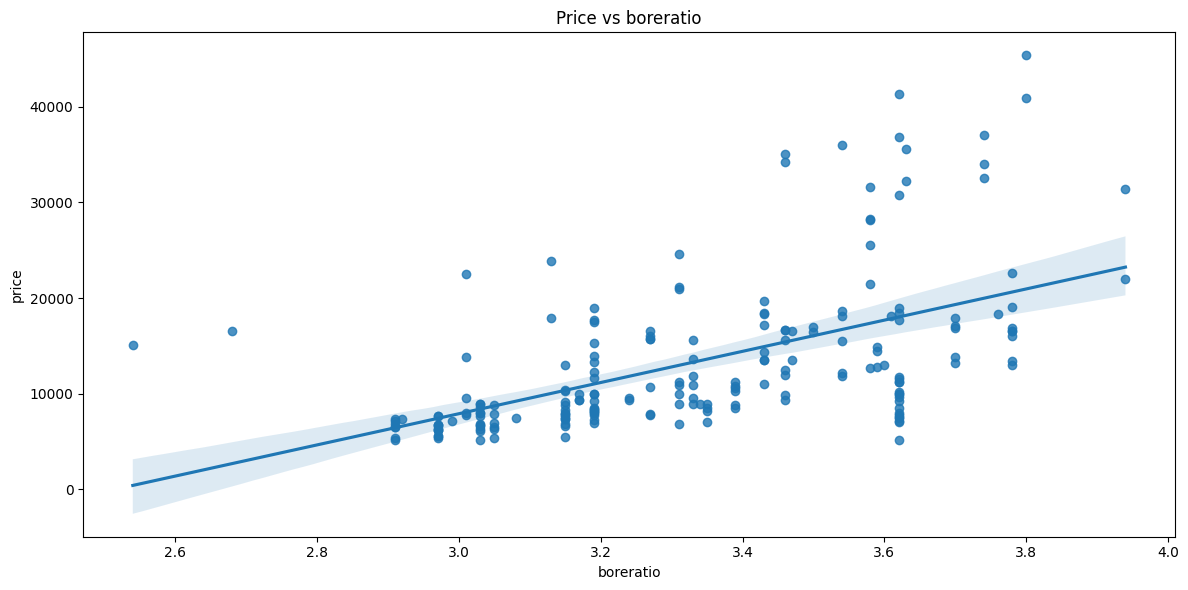

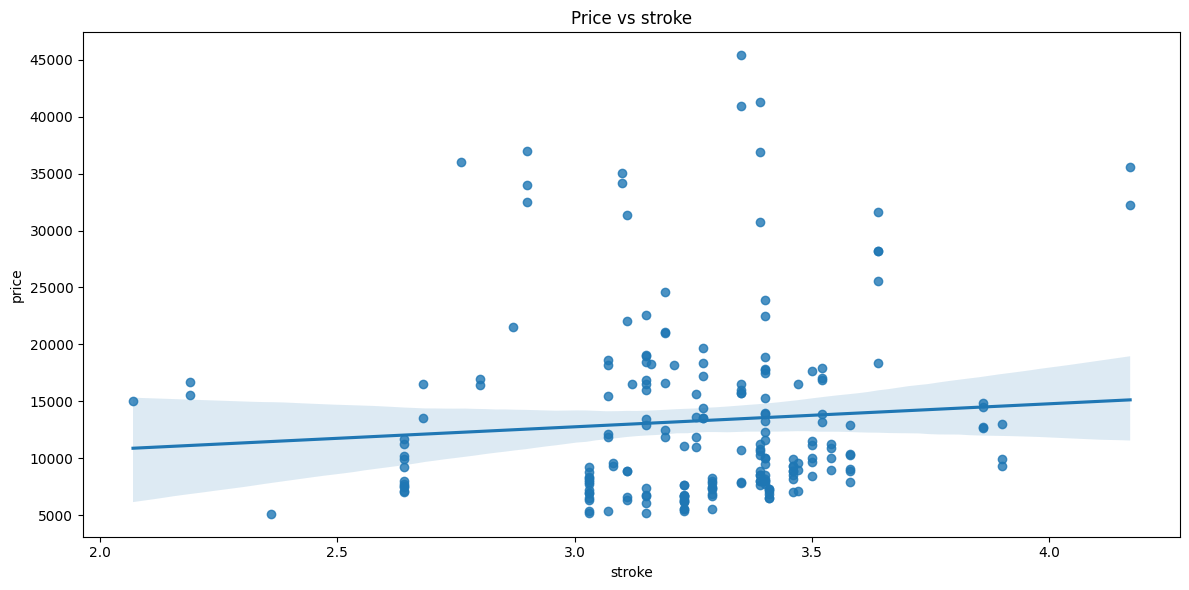

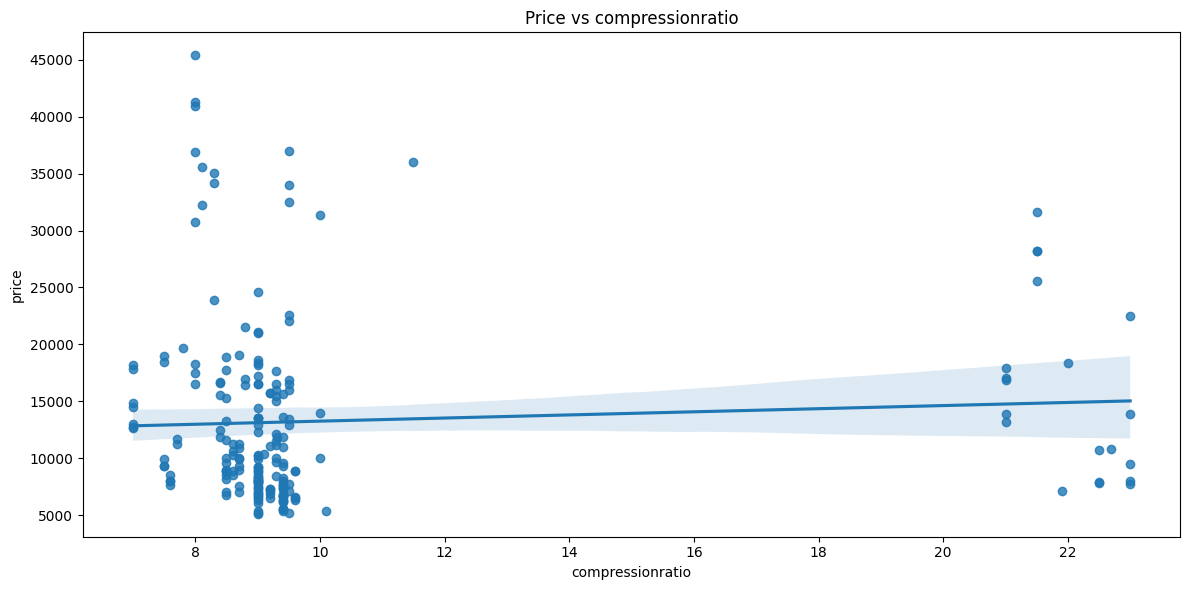

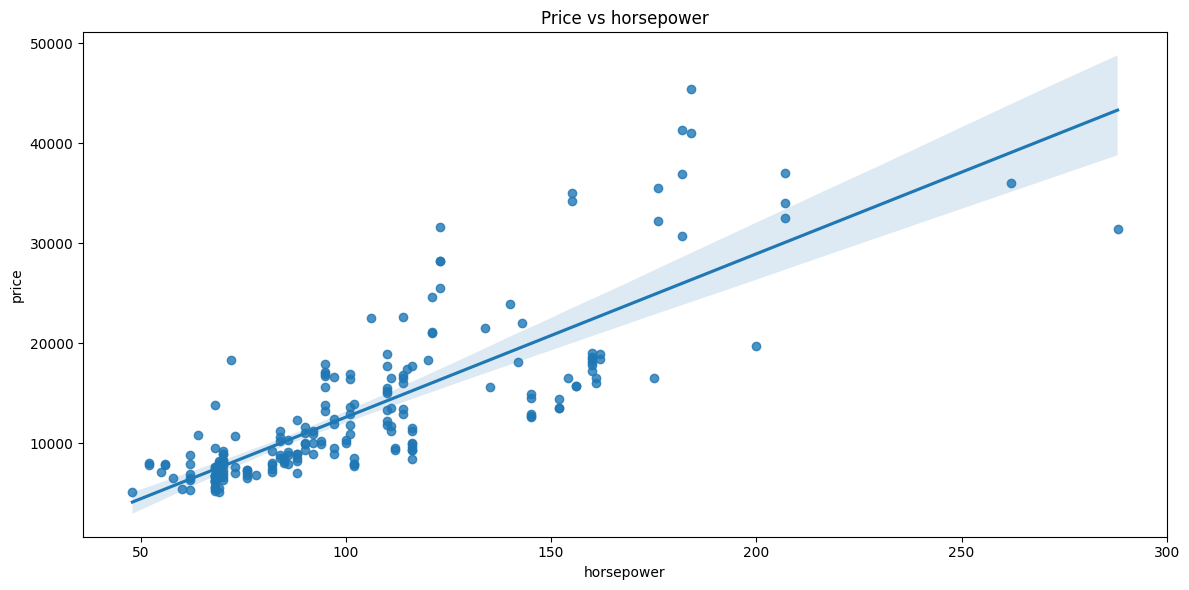

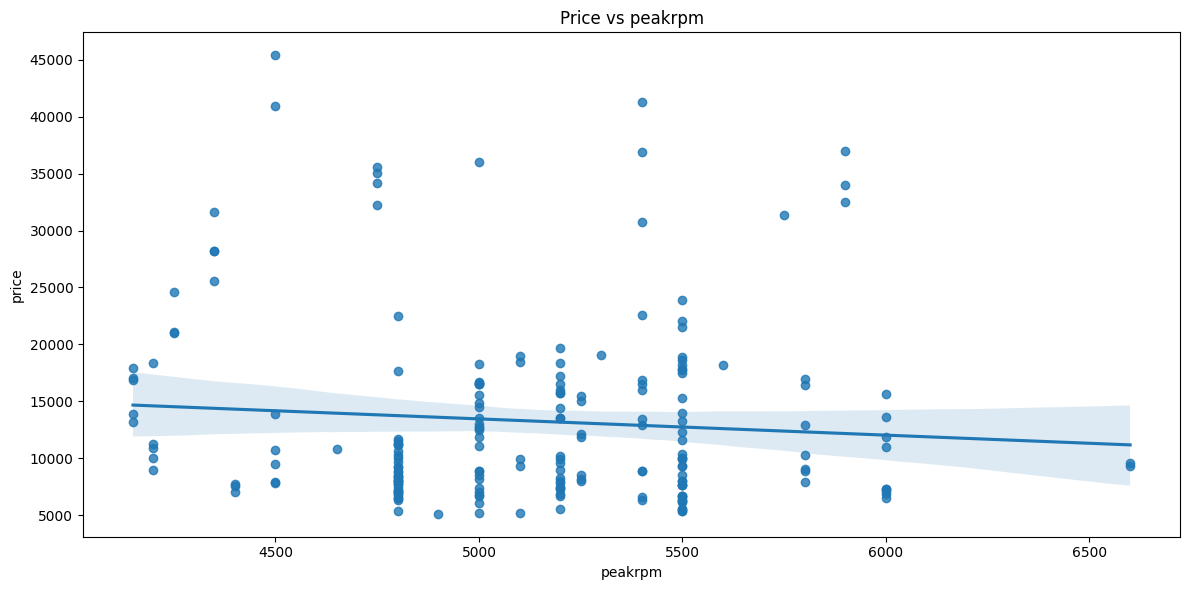

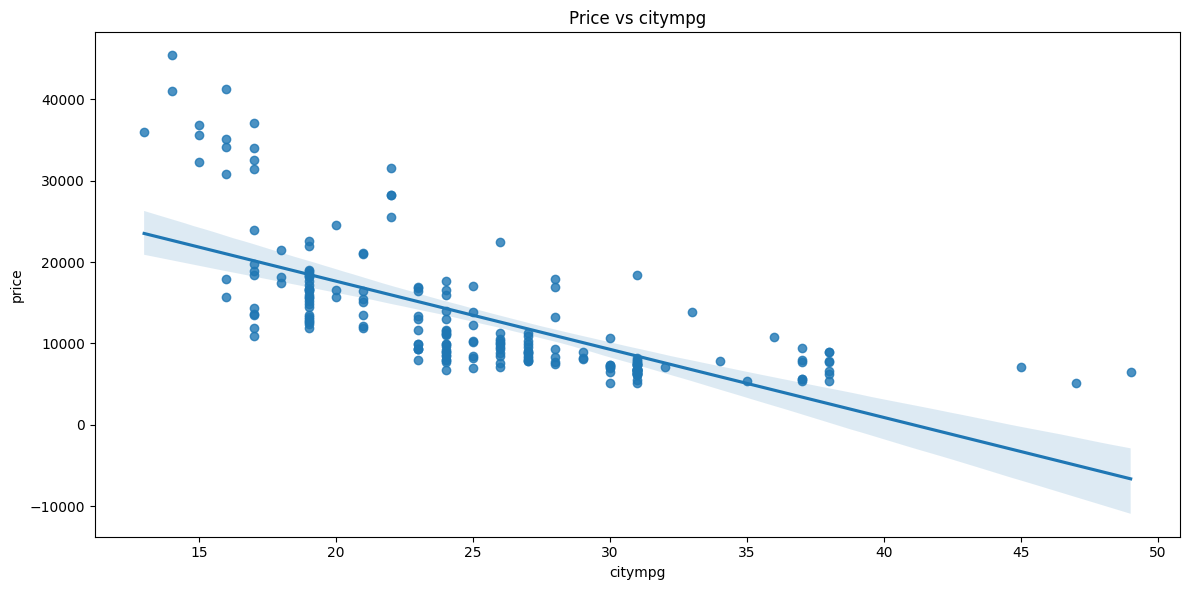

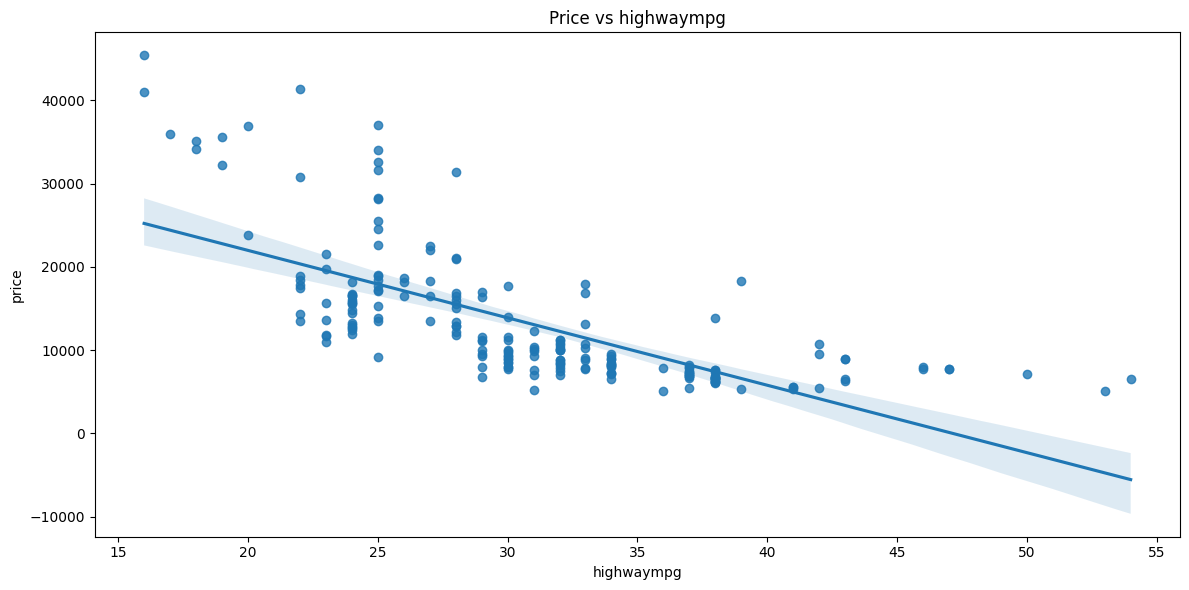

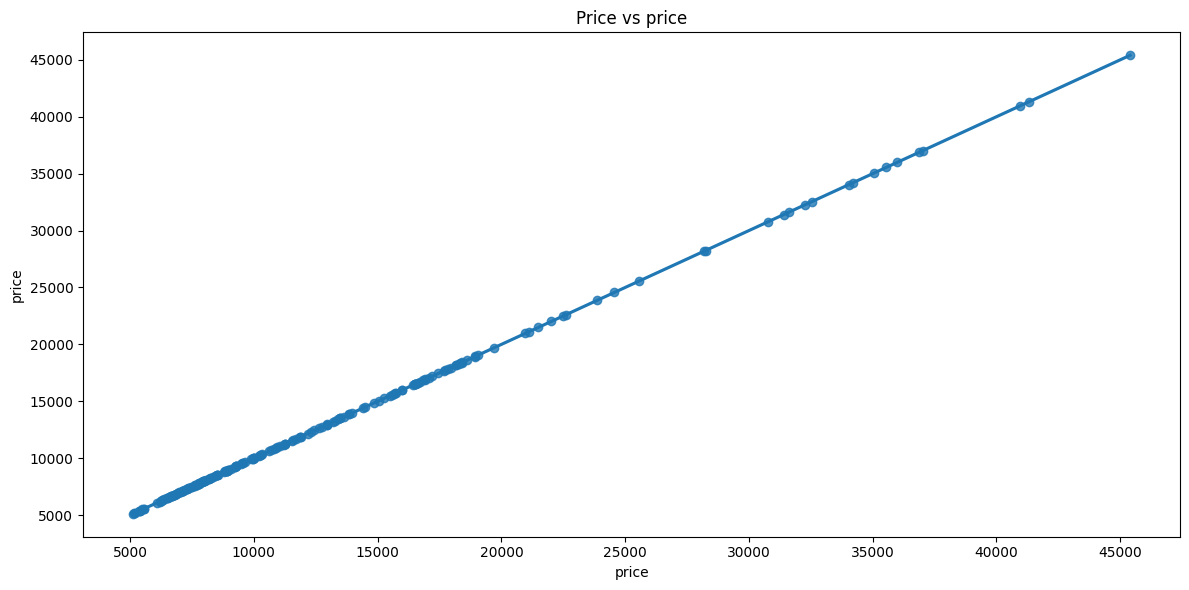

In [9]:
numeric_columns = data.select_dtypes(include = ['float64', 'int64']).columns
for col in numeric_columns:
    plt.figure(figsize=(12,6))
    sns.regplot(x=col, y='price', data=data)
    plt.title(f'Price vs {col}')
    plt.tight_layout()
    plt.show()
   

Explore relationships between features and price using  correlation analysis


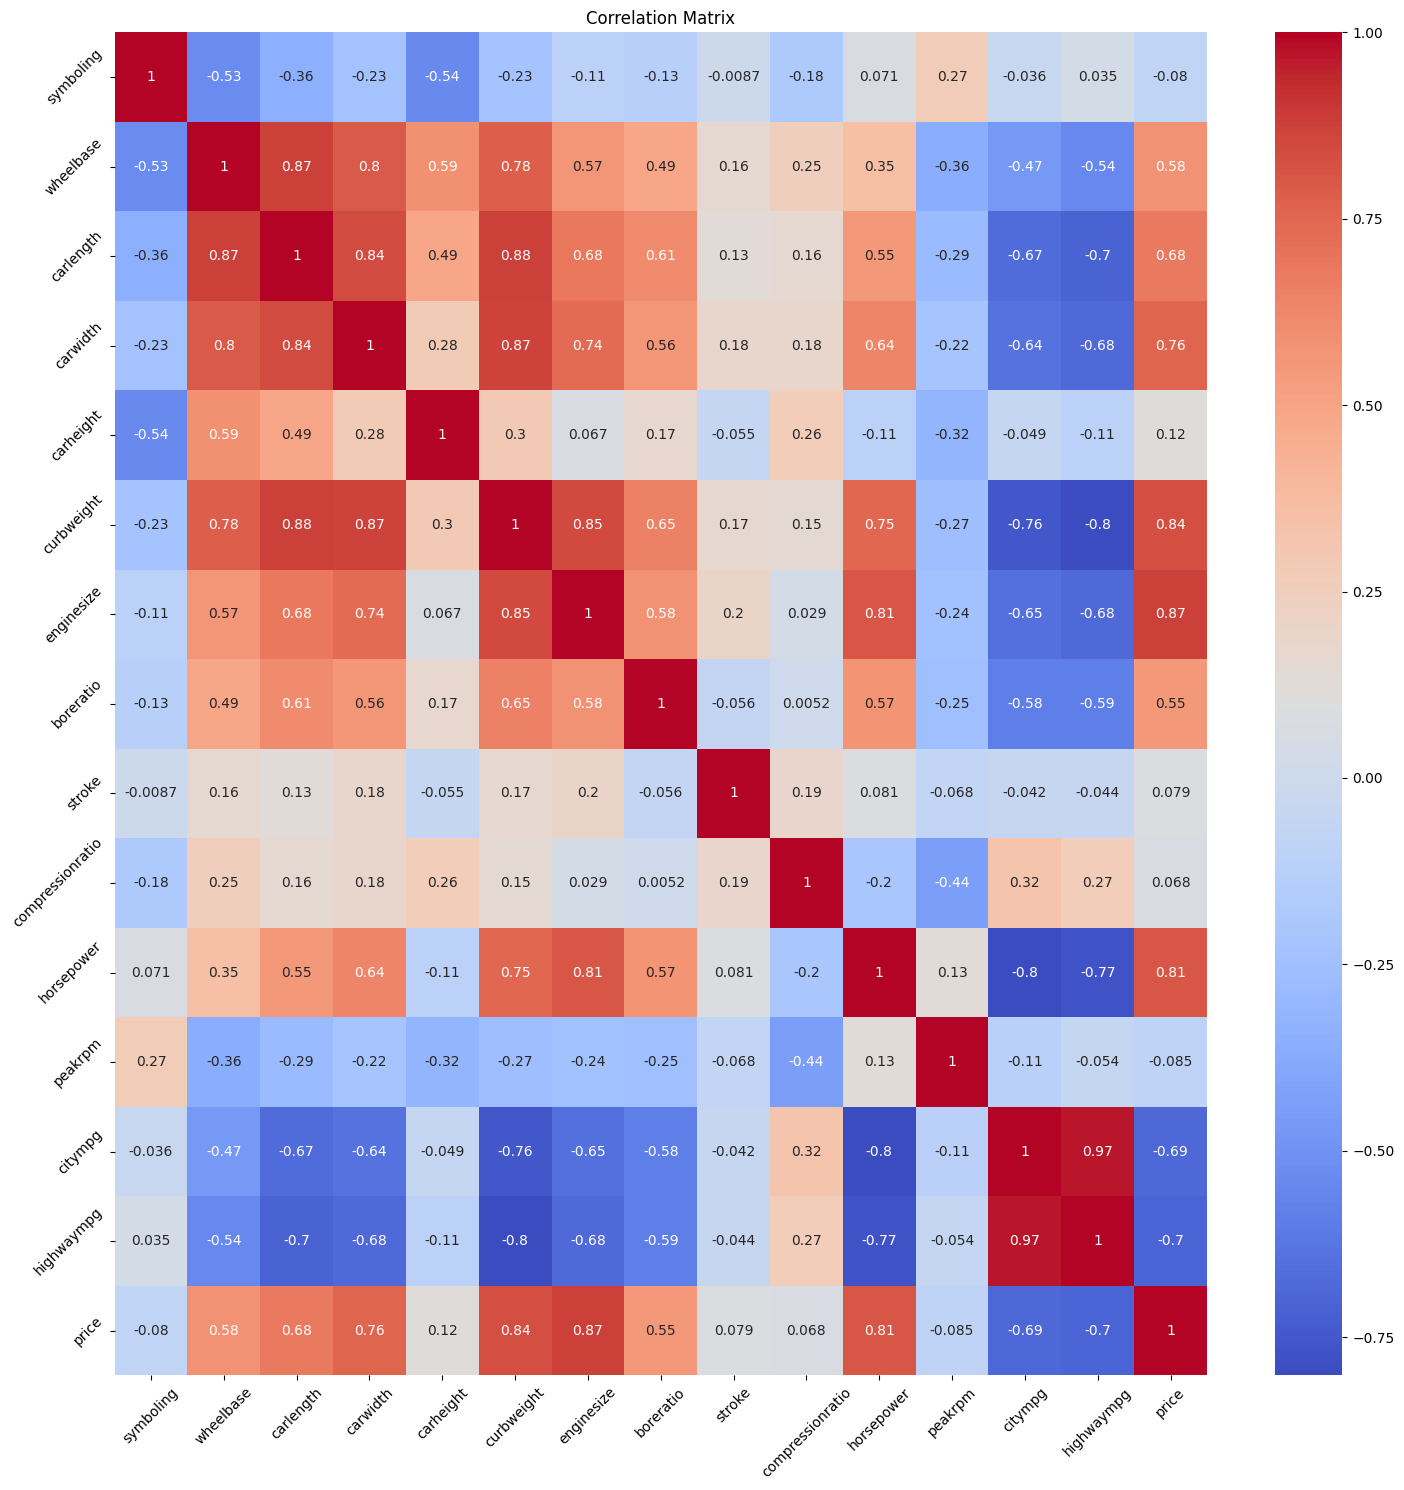

In [10]:
correlation_matrix = data.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [11]:
corr_matrix = data.select_dtypes(include=['int64', 'float64']).corr()
# df.select_dtypes(include=['int64', 'float64'])
corr_matrix['price'].sort_values(ascending=False)

price               1.000000
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
symboling          -0.079978
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

Clean and encode categorical features: standardize text and convert to numeric values


In [12]:
data['doornumber'] = data['doornumber'].str.lower().str.strip()
data['doornumber'] = data['doornumber'].map({'two': 2, 'four': 4})
data['doornumber'] = data['doornumber'].astype(int)


In [13]:
# fueltype: gas=0, diesel=1
data['fueltype'] = data['fueltype'].map({'gas': 0, 'diesel': 1}).astype(int)

# aspiration: std=0, turbo=1
data['aspiration'] = data['aspiration'].map({'std': 0, 'turbo': 1}).astype(int)

# enginelocation: front=0, rear=1
data['enginelocation'] = data['enginelocation'].map({'front': 0, 'rear': 1}).astype(int)

# Check result
print(data[['fueltype','aspiration','enginelocation']].head(10))


   fueltype  aspiration  enginelocation
0         0           0               0
1         0           0               0
2         0           0               0
3         0           0               0
4         0           0               0
5         0           0               0
6         0           0               0
7         0           0               0
8         0           1               0
9         0           1               0


In [14]:
# Example column: cylindernumber
data['cylindernumber'] = data['cylindernumber'].str.lower().str.strip()  # clean text

# Map words to integers
num_map = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}

data['cylindernumber'] = data['cylindernumber'].map(num_map)

# Convert to int (optional if you want to be sure)
data['cylindernumber'] = data['cylindernumber'].astype(int)

# Check result
print(data['cylindernumber'].unique())


[ 4  6  5  3 12  2  8]


In [15]:
# List of columns to encode
cat_cols = ['CarBrand', 'carbody', 'drivewheel', 'enginetype', 'fuelsystem']

# Convert text categories into binary columns
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 66 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   symboling             205 non-null    int64  
 1   fueltype              205 non-null    int64  
 2   aspiration            205 non-null    int64  
 3   doornumber            205 non-null    int64  
 4   enginelocation        205 non-null    int64  
 5   wheelbase             205 non-null    float64
 6   carlength             205 non-null    float64
 7   carwidth              205 non-null    float64
 8   carheight             205 non-null    float64
 9   curbweight            205 non-null    int64  
 10  cylindernumber        205 non-null    int64  
 11  enginesize            205 non-null    int64  
 12  boreratio             205 non-null    float64
 13  stroke                205 non-null    float64
 14  compressionratio      205 non-null    float64
 15  horsepower            2

Separate target variable (price) from the feature set


In [17]:
y = data['price']
X = data.drop('price', axis = 1)

Split dataset into training and testing sets (train_test_split).

In [18]:
X_train ,X_test, y_train ,y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)
# Print the shape of the splits
print(f"Train features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train features shape: (164, 65)
Test features shape: (41, 65)
Train labels shape: (164,)
Test labels shape: (41,)


Scale numerical features using StandardScaler to normalize X_train and X_test


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Define a function to compute evaluation metrics (MAE, MSE, RMSE, R²) for both train and test sets

Initialize a list to store model evaluation results


In [20]:
def error_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    
    errors = {}
    
    # Errors for train data
    errors["Train_MAE"] = mean_absolute_error(y_train_true, y_train_pred)
    errors["Train_MSE"] = mean_squared_error(y_train_true, y_train_pred)
    errors["Train_RMSE"] = np.sqrt(errors["Train_MSE"])
    errors["Train_R2_Score"] = r2_score(y_train_true, y_train_pred)
    
    # Errors for test data
    errors["Test_MAE"] = mean_absolute_error(y_test_true, y_test_pred)
    errors["Test_MSE"] = mean_squared_error(y_test_true, y_test_pred)
    errors["Test_RMSE"] = np.sqrt(errors["Test_MSE"])
    errors["Test_R2_Score"] = r2_score(y_test_true, y_test_pred)
    
    return errors

model_evaluation = []

Linear Regression

In [21]:
lr = LinearRegression()

lr.fit(X_train_scaled, y_train)
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

error_lr = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_lr['Model Name']='Linear Regression'
error_lr

model_evaluation = pd.DataFrame([error_lr])
model_evaluation


,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,931.332748,1.591756e+06,1261.648303,0.97331,1950.467447,8.130815e+06,2851.458344,0.897005,Linear Regression


Ridge Regression

In [22]:
pipe = Pipeline([
    ('scale',StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', Ridge())
])
pipe
param_grid = {'model__alpha': [0.01, 0.1, 1, 10, 100],
    'poly__degree': [1, 2, 3, 4]
}
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model_ridge = grid_search.best_estimator_
print(best_model_ridge)

Pipeline(steps=[('scale', StandardScaler()),
                ('poly', PolynomialFeatures(degree=1)),
                ('model', Ridge(alpha=10))])


In [23]:
Ridge = Ridge()
Ridge.fit(X_train_scaled, y_train)
y_train_pred = Ridge.predict(X_train_scaled)
y_test_pred = Ridge.predict(X_test_scaled)
error_Ridge = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_Ridge['Model Name']='Ridge'
error_Ridge
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_Ridge]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,931.332748,1.591756e+06,1261.648303,0.973310,1950.467447,8.130815e+06,2851.458344,0.897005,Linear Regression
1,931.836575,1.638170e+06,1279.910273,0.972531,1936.865366,8.692996e+06,2948.388637,0.889884,Ridge



Lasso

In [24]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures()),
    ('model', Lasso())
])
pipe

param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100],
    'poly__degree': [1, 2, 3]
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model_lasso = grid_search.best_estimator_
print(best_model_lasso)

Pipeline(steps=[('scale', StandardScaler()), ('poly', PolynomialFeatures()),
                ('model', Lasso(alpha=10))])


In [25]:
Lasso = Lasso()
Lasso.fit(X_train_scaled, y_train)
y_train_pred = Lasso.predict(X_train_scaled)
y_test_pred = Lasso.predict(X_test_scaled)
error_Lasso = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_Lasso['Model Name']='Lasso'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_Lasso]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,931.332748,1.591756e+06,1261.648303,0.973310,1950.467447,8.130815e+06,2851.458344,0.897005,Linear Regression
1,931.836575,1.638170e+06,1279.910273,0.972531,1936.865366,8.692996e+06,2948.388637,0.889884,Ridge
2,929.204344,1.593932e+06,1262.510111,0.973273,1936.896528,8.089191e+06,2844.150228,0.897533,Lasso


Decision Trees



In [26]:
mod_tree = DecisionTreeRegressor(random_state=42)

param_grid = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'max_depth': np.arange(1,10),
    
}

grid_search = GridSearchCV(mod_tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_tree = grid_search.best_estimator_
print(best_tree)


DecisionTreeRegressor(criterion='absolute_error', max_depth=np.int64(8),
                      random_state=42)


In [27]:
best_tree.fit(X_train, y_train)

y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)

error_tree = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_tree['Model Name'] = 'Decision Tree'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_tree]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,931.332748,1.591756e+06,1261.648303,0.973310,1950.467447,8.130815e+06,2851.458344,0.897005,Linear Regression
1,931.836575,1.638170e+06,1279.910273,0.972531,1936.865366,8.692996e+06,2948.388637,0.889884,Ridge
2,929.204344,1.593932e+06,1262.510111,0.973273,1936.896528,8.089191e+06,2844.150228,0.897533,Lasso
3,380.670732,8.254990e+05,908.569770,0.986158,1932.178854,7.884062e+06,2807.857120,0.900131,Decision Tree


Random Forest



In [28]:
random_forest = RandomForestRegressor()
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['squared_error', 'friedman_mse',],
    'max_depth': np.arange(1,10),
    'min_samples_split': np.arange(1,10)
}

grid_search = GridSearchCV(random_forest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_forest = grid_search.best_estimator_
print(best_forest)

RandomForestRegressor(criterion='friedman_mse', max_depth=np.int64(7),
                      min_samples_split=np.int64(4))


In [29]:
best_forest.fit(X_train, y_train)
y_train_pred = best_forest.predict(X_train)
y_test_pred = best_forest.predict(X_test)

error_random_forest = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_random_forest['Model Name'] = 'Random Forest'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_random_forest]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,931.332748,1.591756e+06,1261.648303,0.973310,1950.467447,8.130815e+06,2851.458344,0.897005,Linear Regression
1,931.836575,1.638170e+06,1279.910273,0.972531,1936.865366,8.692996e+06,2948.388637,0.889884,Ridge
2,929.204344,1.593932e+06,1262.510111,0.973273,1936.896528,8.089191e+06,2844.150228,0.897533,Lasso
3,380.670732,8.254990e+05,908.569770,0.986158,1932.178854,7.884062e+06,2807.857120,0.900131,Decision Tree
4,749.810011,1.163110e+06,1078.475599,0.980497,1279.743265,3.430796e+06,1852.240868,0.956541,Random Forest


Gradient Boosting Regressor

In [30]:
gbr = GradientBoostingRegressor()

param_grid_gbr = {
    'n_estimators': [100, 200, 300],              # number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # shrinkage rate
    'max_depth': [2, 3, 4, 5],                    # depth of individual trees
    'min_samples_split': [2, 4, 6],               # minimum split for nodes
    'min_samples_leaf': [1, 2, 3]                 # minimum number of samples in leaves
}

grid_search_gbr = GridSearchCV(
    gbr,
    param_grid_gbr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search_gbr.fit(X_train, y_train)

best_gbr = grid_search_gbr.best_estimator_
print(best_gbr)

GradientBoostingRegressor(max_depth=2, min_samples_leaf=2, min_samples_split=4,
                          n_estimators=300)


In [31]:
best_gbr.fit(X_train, y_train)
y_train_pred = best_gbr.predict(X_train)
y_test_pred = best_gbr.predict(X_test)

error_random_gbr = error_metrics(y_train, y_train_pred, y_test, y_test_pred)
error_random_gbr['Model Name'] = 'GradientBoostingRegressor'
model_evaluation = pd.concat([model_evaluation, (pd.DataFrame([error_random_gbr]))], ignore_index=True)
model_evaluation

,Train_MAE,Train_MSE,Train_RMSE,Train_R2_Score,Test_MAE,Test_MSE,Test_RMSE,Test_R2_Score,Model Name
0,931.332748,1.591756e+06,1261.648303,0.973310,1950.467447,8.130815e+06,2851.458344,0.897005,Linear Regression
1,931.836575,1.638170e+06,1279.910273,0.972531,1936.865366,8.692996e+06,2948.388637,0.889884,Ridge
2,929.204344,1.593932e+06,1262.510111,0.973273,1936.896528,8.089191e+06,2844.150228,0.897533,Lasso
3,380.670732,8.254990e+05,908.569770,0.986158,1932.178854,7.884062e+06,2807.857120,0.900131,Decision Tree
4,749.810011,1.163110e+06,1078.475599,0.980497,1279.743265,3.430796e+06,1852.240868,0.956541,Random Forest
5,460.177252,3.920753e+05,626.159147,0.993426,1677.570799,5.233939e+06,2287.780278,0.933701,GradientBoostingRegressor


# Observations

Linear Regression, Ridge, Lasso

Similar performance; good R² on train (≈0.97) and test (≈0.89–0.90).
RMSE on test is quite high (~2800), so predictions may not be very precise for high-priced cars.

Decision Tree

Very low train RMSE (≈909) and high train R² (0.986) → slight overfitting.

Test RMSE ≈2808, test R² ≈0.90 → slightly better than linear models.

Random Forest

Slightly higher train RMSE than Decision Tree (938) but lower test RMSE (≈1750) and very high test R² (0.961).

Indicates Random Forest generalizes best among all models.

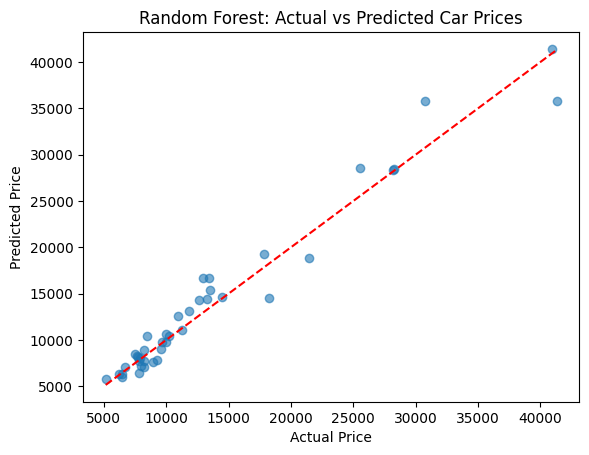

In [32]:

y_test_pred = best_forest.predict(X_test) 
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs Predicted Car Prices")
plt.show()
